#  **Dirty Cafe Items Analysis**
First let's import and explore the dataset

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [138]:
dirty_cafe = pd.read_csv("..\data\dirty_cafe_sales.csv")
dirty_cafe.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


In [139]:
dirty_cafe.shape

(10000, 8)

In [140]:
dirty_cafe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   object
 3   Price Per Unit    9821 non-null   object
 4   Total Spent       9827 non-null   object
 5   Payment Method    7421 non-null   object
 6   Location          6735 non-null   object
 7   Transaction Date  9841 non-null   object
dtypes: object(8)
memory usage: 625.1+ KB


In [141]:
dirty_cafe.nunique()

Transaction ID      10000
Item                   10
Quantity                7
Price Per Unit          8
Total Spent            19
Payment Method          5
Location                4
Transaction Date      367
dtype: int64

In [142]:
dirty_cafe.describe()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
count,10000,9667,9862,9821,9827,7421,6735,9841
unique,10000,10,7,8,19,5,4,367
top,TXN_6170729,Juice,5,3.0,6.0,Digital Wallet,Takeaway,UNKNOWN
freq,1,1171,2013,2429,979,2291,3022,159


## **Is the dataset clean?**

In [143]:
print(dirty_cafe["Item"].value_counts())


Item
Juice       1171
Coffee      1165
Salad       1148
Cake        1139
Sandwich    1131
Smoothie    1096
Cookie      1092
Tea         1089
UNKNOWN      344
ERROR        292
Name: count, dtype: int64


We can see that the this coulumn have Unkown and Error Values , also the rest of the columns have the same issue.

In [144]:
bad_values = ["ERROR", "UNKNOWN"]

columns_to_clean = ["Quantity", "Total Spent", "Price Per Unit","Item","Transaction Date","Location","Payment Method","Transaction ID"]

for col in columns_to_clean:
    dirty_cafe[col] = dirty_cafe[col].replace(bad_values, np.nan)

In [145]:
dirty_cafe.dtypes

Transaction ID      object
Item                object
Quantity            object
Price Per Unit      object
Total Spent         object
Payment Method      object
Location            object
Transaction Date    object
dtype: object

We notice that the data types for all columns is object which will not be suitable for our analysis ,  so let's solve it.

In [146]:
dirty_cafe["Quantity"] = dirty_cafe["Quantity"].astype(float)
dirty_cafe["Total Spent"] = dirty_cafe["Total Spent"].astype(float)
dirty_cafe["Price Per Unit"] = dirty_cafe["Price Per Unit"].astype(float)
dirty_cafe["Item"] = dirty_cafe["Item"].astype('category')
dirty_cafe["Payment Method"] = dirty_cafe["Payment Method"].astype('category')
dirty_cafe["Location"] = dirty_cafe["Location"].astype('category')
dirty_cafe["Transaction Date"] = pd.to_datetime(dirty_cafe["Transaction Date"])

In [147]:
dirty_cafe.dtypes

Transaction ID              object
Item                      category
Quantity                   float64
Price Per Unit             float64
Total Spent                float64
Payment Method            category
Location                  category
Transaction Date    datetime64[ns]
dtype: object

After casting columns to suitable data types we should look in for  null values in the dataset . if there is null values we must impute it with meaningfull values. 

In [148]:
print(dirty_cafe.isna().sum())

Transaction ID         0
Item                 969
Quantity             479
Price Per Unit       533
Total Spent          502
Payment Method      3178
Location            3961
Transaction Date     460
dtype: int64


In [149]:
def fill_quantity(x):
    m = x.mode()
    if len(m) > 0:
        return m.iloc[0]  
    else:
        return int(x.median())  


In [150]:
dirty_cafe["Quantity"] = dirty_cafe.groupby("Item")["Quantity"].transform(lambda x: x.fillna(fill_quantity(x)))
dirty_cafe["Price Per Unit"] = dirty_cafe["Price Per Unit"].fillna(dirty_cafe.groupby("Item")["Price Per Unit"].transform("mean"))
dirty_cafe["Total Spent"] = dirty_cafe["Total Spent"].fillna(dirty_cafe["Quantity"]*dirty_cafe["Price Per Unit"])


dirty_cafe["Item"] = dirty_cafe["Item"].fillna(dirty_cafe["Item"].mode()[0])
dirty_cafe["Payment Method"] = dirty_cafe["Payment Method"].fillna(dirty_cafe["Payment Method"].mode()[0])
dirty_cafe["Location"] = dirty_cafe["Location"].fillna(dirty_cafe["Location"].mode()[0])


dirty_cafe["Transaction Date"] = dirty_cafe["Transaction Date"].ffill().bfill()


C:\Users\moust\AppData\Local\Temp\ipykernel_15128\821509519.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dirty_cafe["Quantity"] = dirty_cafe.groupby("Item")["Quantity"].transform(lambda x: x.fillna(fill_quantity(x)))
C:\Users\moust\AppData\Local\Temp\ipykernel_15128\821509519.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dirty_cafe["Price Per Unit"] = dirty_cafe["Price Per Unit"].fillna(dirty_cafe.groupby("Item")["Price Per Unit"].transform("mean"))


In [151]:
print(dirty_cafe.isna().sum())

Transaction ID        0
Item                  0
Quantity            969
Price Per Unit       54
Total Spent          50
Payment Method        0
Location              0
Transaction Date      0
dtype: int64


Now we solved missing values problem in the dataset , it is time to check if there is aduplicate inputs to be dropped.

In [152]:
dirty_cafe.duplicated().sum()

np.int64(0)

After reviewing that dataset dosen't have any duplicates , now we will extract the time columns that will help us in our time-based analysis later . 
we will also delete unneccesry columns

In [153]:
dirty_cafe["Transaction Year"] = dirty_cafe["Transaction Date"].dt.year
dirty_cafe["Transaction Month"] = dirty_cafe["Transaction Date"].dt.month_name()
dirty_cafe["Transaction Day"] = dirty_cafe["Transaction Date"].dt.day_name()


In [154]:
del dirty_cafe["Transaction ID"]
del dirty_cafe["Transaction Date"]


In [155]:
dirty_cafe.head()

,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Year,Transaction Month,Transaction Day
0,Coffee,2.0,2.0,4.0,Credit Card,Takeaway,2023,September,Friday
1,Cake,4.0,3.0,12.0,Cash,In-store,2023,May,Tuesday
2,Cookie,4.0,1.0,4.0,Credit Card,In-store,2023,July,Wednesday
3,Salad,2.0,5.0,10.0,Digital Wallet,Takeaway,2023,April,Thursday
4,Coffee,2.0,2.0,4.0,Digital Wallet,In-store,2023,June,Sunday


#### **Now The Dataset is Clean**
# **Let's start our Items Analysis**

**which item makes the highest number of Orders**

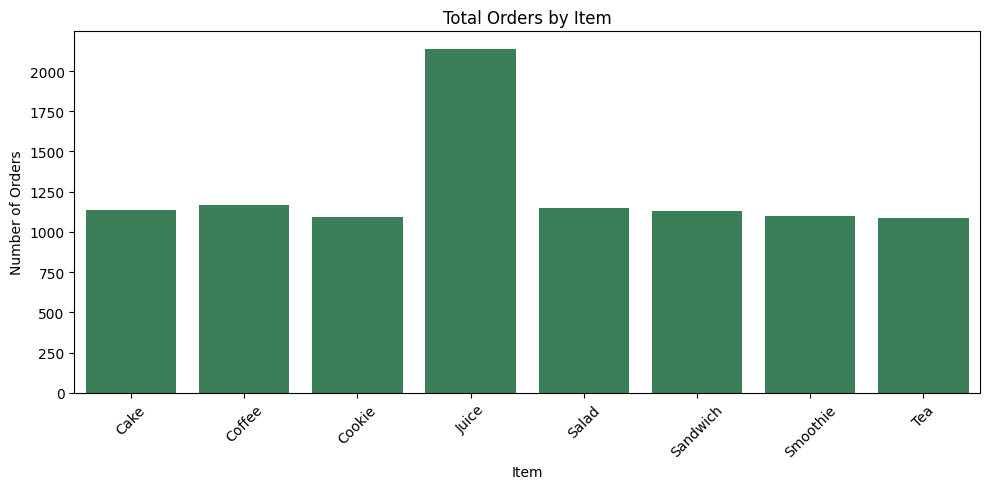

In [156]:
plt.figure(figsize=(10,5))
sns.countplot(dirty_cafe,x="Item",color="#2E8B57")
plt.xlabel("Item")
plt.ylabel("Number of Orders")
plt.title("Total Orders by Item")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**It appears that Juice has the highest number of orders, with approximately twice as many orders as the other items, which all range between 1,000 and 1,250 orders.**

**We observed that Juice is the most ordered item, but does that also mean it is the item with the highest number of pieces ordered**

C:\Users\moust\AppData\Local\Temp\ipykernel_15128\787599005.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  item_quantity_sum = dirty_cafe.groupby("Item").agg({"Quantity":"sum"})


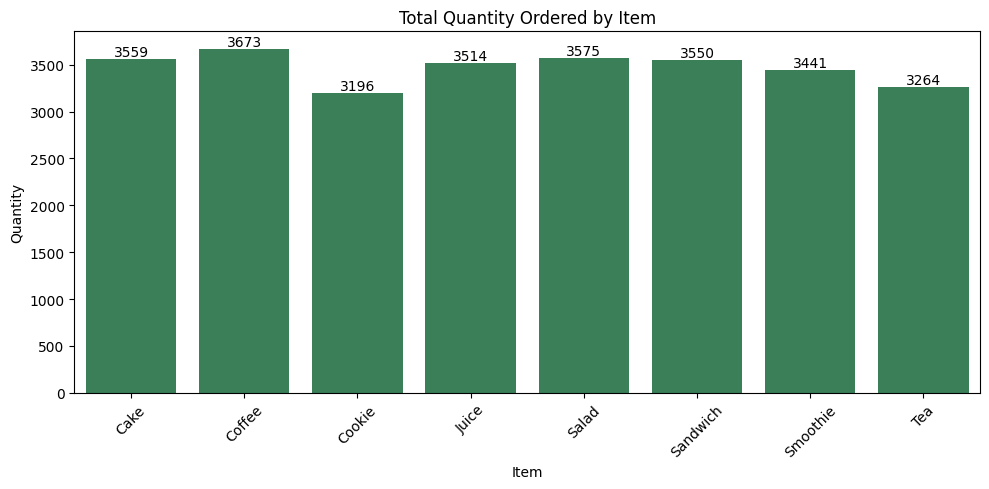

In [157]:
item_quantity_sum = dirty_cafe.groupby("Item").agg({"Quantity":"sum"})
item_quantity_sum = item_quantity_sum.sort_values(by="Quantity",ascending=True)

plt.figure(figsize=(10,5))
ax = sns.barplot(x="Item", y="Quantity", data=item_quantity_sum , color="#2E8B57")
for i, row in item_quantity_sum.iterrows():
    ax.text(
        i, row["Quantity"],f"{row['Quantity']:.0f}",ha='center', va='bottom')
plt.ylabel("Quantity")
plt.xlabel("Item")
plt.title("Total Quantity Ordered by Item")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**It appears that Juice isn't the item with the most pieces ordered. In fact, it barely makes it into the top 5, trailing behind Coffee, Salad, Cake, and Sandwich. Cookie comes last behind smothie and Tea, with about a 15% drop in orders compared to Coffee. However, the gap between Juice and the top item is relatively small, with only around 150 fewer pieces ordered.** 
#### **But why?**

C:\Users\moust\AppData\Local\Temp\ipykernel_15128\632964084.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  item_quantity_mode = (dirty_cafe.groupby("Item")["Quantity"].agg(lambda x: x.mode().iloc[0]))


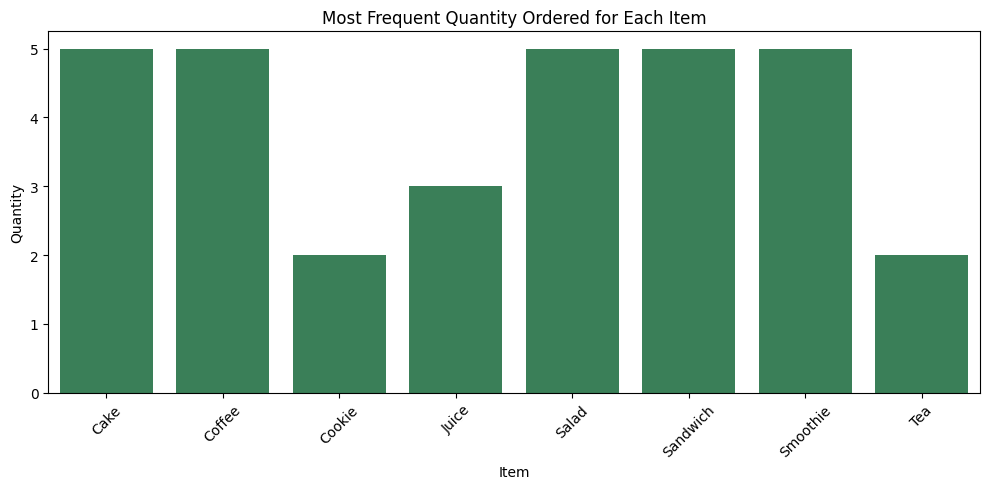

In [158]:
item_quantity_mode = (dirty_cafe.groupby("Item")["Quantity"].agg(lambda x: x.mode().iloc[0]))
item_quantity_mode = item_quantity_mode.sort_values(ascending=True)

plt.figure(figsize=(10,5))
sns.barplot(x=item_quantity_mode.index, y=item_quantity_mode.values ,color="#2E8B57")
plt.ylabel("Quantity")
plt.xlabel("Item")
plt.title("Most Frequent Quantity Ordered for Each Item")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**It seems that most customers who order Juice typically order 3 pieces, while the majority of customers order 5 pieces of other items. In contrast, customers tend to order only 2 pieces of Cookies and Tea , But is this the only Factor.**

C:\Users\moust\AppData\Local\Temp\ipykernel_15128\2805126468.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  item_price = dirty_cafe.groupby("Item")["Price Per Unit"].max()


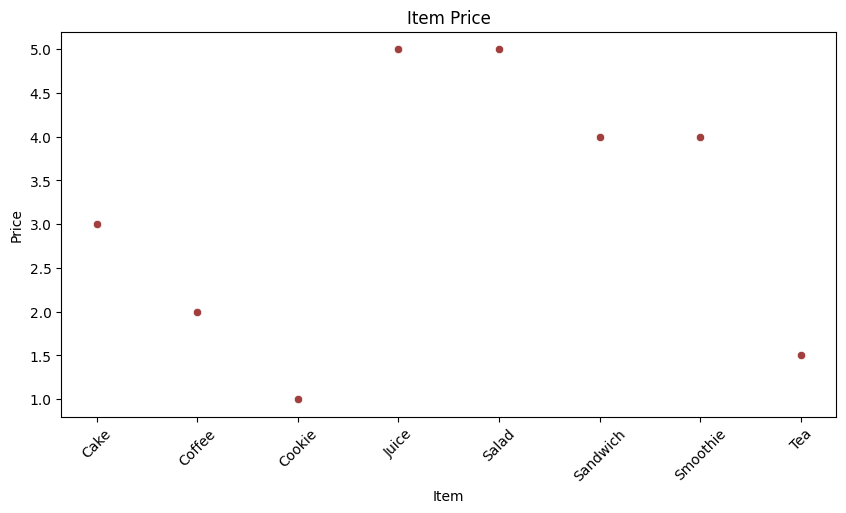

In [159]:
item_price = dirty_cafe.groupby("Item")["Price Per Unit"].max()
plt.figure(figsize=(10,5))
sns.scatterplot(x=item_price.index,y=item_price.values,color="#A13F3F")
plt.xlabel("Item")
plt.ylabel("Price")
plt.title("Item Price")
plt.xticks(rotation=45)
plt.show()

**It also appears that Juice has the highest price at $5, while Coffee, its direct competitor, is priced at only $2, which may help explain the difference in sales. However, with Cookie and Tea priced lower at $1 and $1.50 respectively, this raises the question: Do customers still prefer ordering these items,and are we serve a good cookie and Tea, and are we marketing them effectively?**

C:\Users\moust\AppData\Local\Temp\ipykernel_15128\2165907523.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  item_sales = dirty_cafe.groupby("Item").agg({"Total Spent":"sum"})


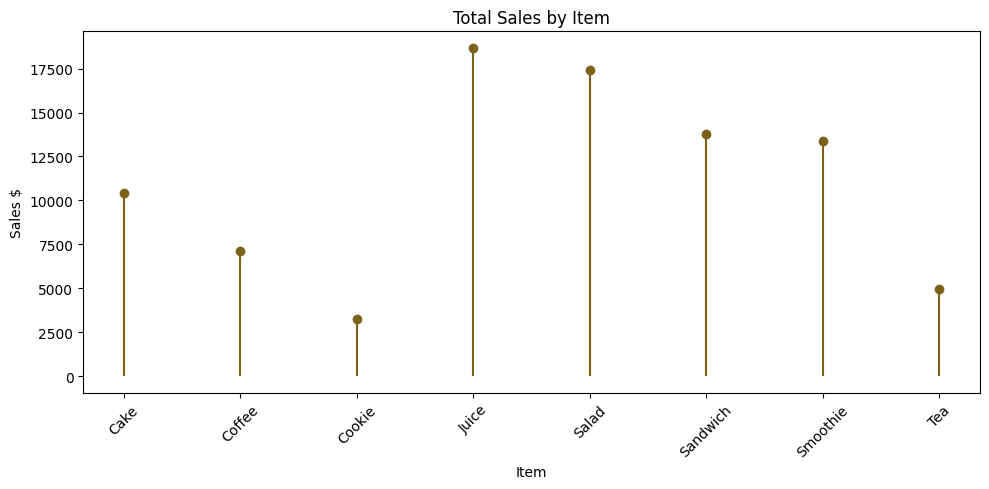

In [160]:
plt.figure(figsize=(10,5))
item_sales = dirty_cafe.groupby("Item").agg({"Total Spent":"sum"})
plt.stem(item_sales.index, item_sales.values, 
        linefmt="#7B611A", markerfmt="o", basefmt=" ")
plt.xlabel("Item")
plt.ylabel("Sales $")
plt.title("Total Sales by Item")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Overall, it appears that Juice still leads in sales, outpacing Coffee by nearly three times. This raises a question for management: If we reduce the price of Juice slightly, could that result in higher sales? One approach to test this could be through temporary price promotions. Salad comes in second, with sales very close to Juice, while Cookie and Tea remain the weakest performers.**

**Now how Items Performs on Various Payment Method and Location?**

C:\Users\moust\AppData\Local\Temp\ipykernel_15128\2929355538.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Item_Payment = dirty_cafe.groupby(["Item", "Payment Method"]).size().reset_index(name="Order Count")
C:\Users\moust\AppData\Local\Temp\ipykernel_15128\2929355538.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  payment_method_totals = Item_Payment.groupby("Payment Method")["Order Count"].sum()


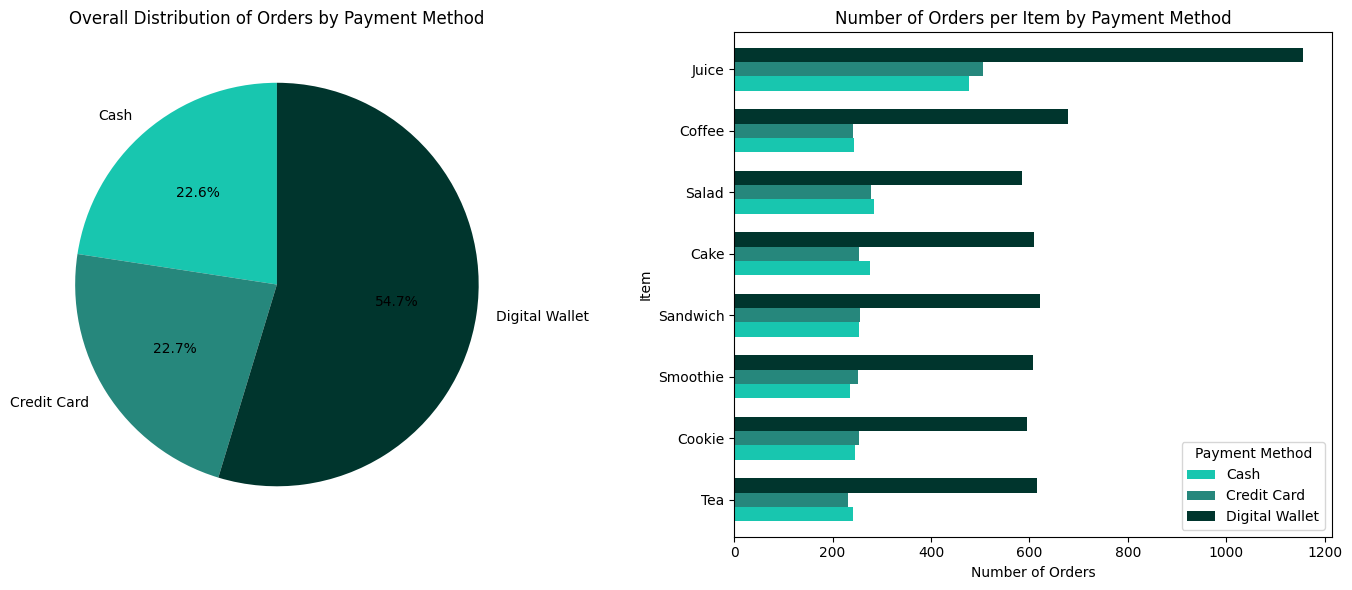

In [161]:

Item_Payment = dirty_cafe.groupby(["Item", "Payment Method"]).size().reset_index(name="Order Count")
item_payment_pivot = Item_Payment.pivot(index="Item", columns="Payment Method", values="Order Count").fillna(0)
item_payment_pivot["Total"] = item_payment_pivot.sum(axis=1)

item_payment_pivot = item_payment_pivot.sort_values("Total", ascending=True)
item_payment_pivot = item_payment_pivot.drop(columns="Total")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
payment_method_totals = Item_Payment.groupby("Payment Method")["Order Count"].sum()

ax1.pie(payment_method_totals, labels=payment_method_totals.index, autopct='%1.1f%%', startangle=90, colors=["#18C6AF", "#26877C", "#00352D"])
ax1.set_title("Overall Distribution of Orders by Payment Method")

item_payment_pivot.plot(kind="barh", stacked=False, color=["#18C6AF", "#26877C", "#00352D"], width=0.7, ax=ax2)
ax2.set_xlabel("Number of Orders")
ax2.set_ylabel("Item")
ax2.set_title("Number of Orders per Item by Payment Method")
ax2.legend(title="Payment Method")
plt.tight_layout()
plt.show()


C:\Users\moust\AppData\Local\Temp\ipykernel_15128\58369533.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Item_Location_count = dirty_cafe.groupby(["Item", "Location"]).size().reset_index(name="Order Count")


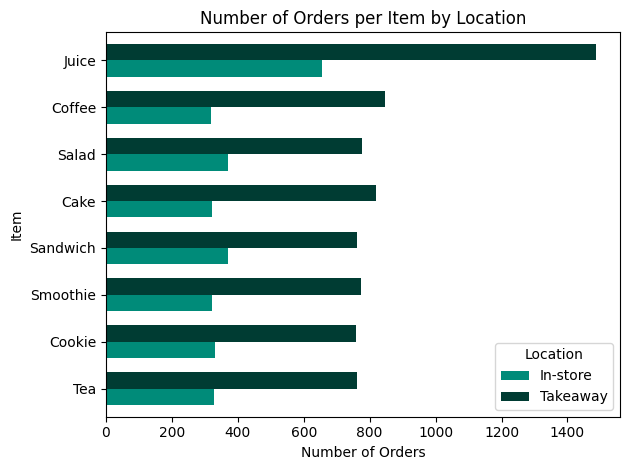

In [162]:
Item_Location_count = dirty_cafe.groupby(["Item", "Location"]).size().reset_index(name="Order Count")
item_location_pivot = Item_Location_count.pivot(index="Item", columns="Location", values="Order Count").fillna(0)

item_location_pivot["Total"] = item_location_pivot.sum(axis=1)
item_location_pivot = item_location_pivot.sort_values("Total", ascending=True)
item_location_pivot = item_location_pivot.drop(columns="Total")
item_location_pivot.plot(kind="barh",stacked=False,color=["#008B79", "#003C33"],width=0.7)

plt.xlabel("Number of Orders")
plt.ylabel("Item")
plt.title("Number of Orders per Item by Location")
plt.legend(title="Location")
plt.tight_layout()
plt.show()

C:\Users\moust\AppData\Local\Temp\ipykernel_15128\2107516751.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Item_Payment_Sales = dirty_cafe.groupby(["Item", "Payment Method"])["Total Spent"].sum().reset_index(name="Total Sales")


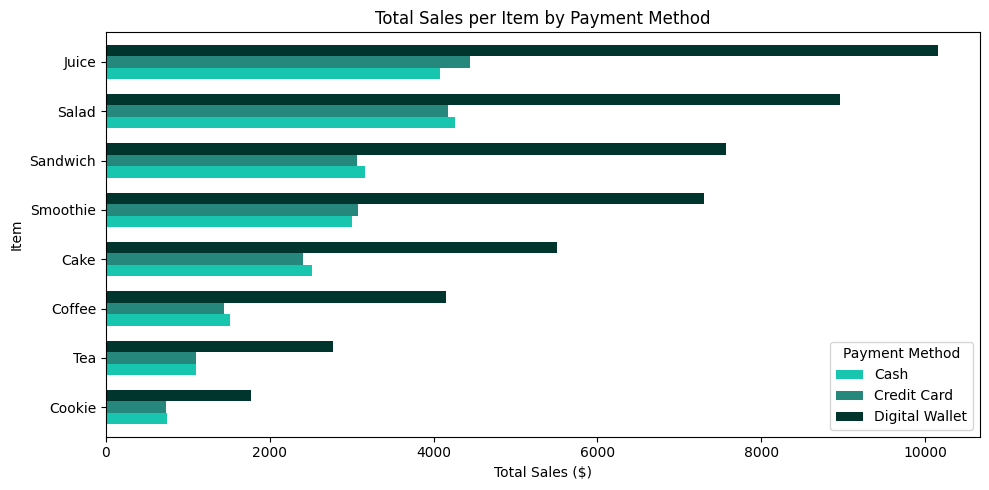

In [163]:
Item_Payment_Sales = dirty_cafe.groupby(["Item", "Payment Method"])["Total Spent"].sum().reset_index(name="Total Sales")
item_payment_sales_pivot = Item_Payment_Sales.pivot(index="Item", columns="Payment Method", values="Total Sales").fillna(0)
item_payment_sales_pivot["Total"] = item_payment_sales_pivot.sum(axis=1)
item_payment_sales_pivot = item_payment_sales_pivot.sort_values("Total", ascending=True)
item_payment_sales_pivot = item_payment_sales_pivot.drop(columns="Total")

fig, ax = plt.subplots(figsize=(10, 5))
item_payment_sales_pivot.plot(kind="barh", stacked=False, color=["#18C6AF", "#26877C", "#00352D"], width=0.7, ax=ax)
ax.set_xlabel("Total Sales ($)")
ax.set_ylabel("Item")
ax.set_title("Total Sales per Item by Payment Method")
ax.legend(title="Payment Method")
plt.tight_layout()
plt.show()

C:\Users\moust\AppData\Local\Temp\ipykernel_15128\3429401007.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  location_sales = dirty_cafe.groupby('Location')['Total Spent'].sum()


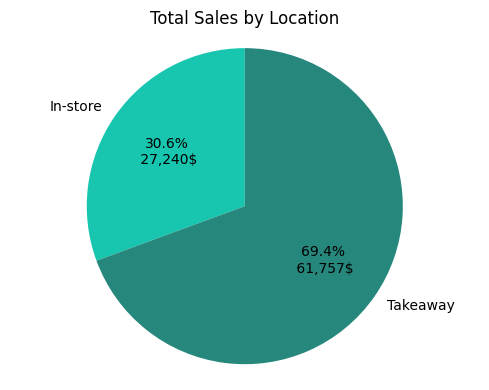

In [164]:
location_sales = dirty_cafe.groupby('Location')['Total Spent'].sum()

plt.figure(figsize=(5, 4))
plt.pie(location_sales, labels=location_sales.index, autopct=lambda pct: f"{pct:.1f}%\n {round(pct / 100.*sum(location_sales), 2):,.0f}$",
        startangle=90, colors=["#18C6AF", "#26877C"])
plt.title("Total Sales by Location")
plt.axis('equal') 

plt.tight_layout()
plt.show()

**It appers That Digital Wallet and Takeaway Comes first in both number of orders and total Sales**

**let's Analyze Our Items performance over Time**

In [165]:
dirty_cafe["Transaction Month"] = pd.Categorical(dirty_cafe["Transaction Month"], 
                                                 categories=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"],
                                                 ordered=True)
dirty_cafe["Transaction Day"] = pd.Categorical(dirty_cafe["Transaction Day"], 
                                               categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
                                               ordered=True)


C:\Users\moust\AppData\Local\Temp\ipykernel_15128\4001810686.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_sales = dirty_cafe.groupby('Transaction Month')['Total Spent'].sum().sort_index()
C:\Users\moust\AppData\Local\Temp\ipykernel_15128\4001810686.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily_sales = dirty_cafe.groupby('Transaction Day')['Total Spent'].sum().sort_index()


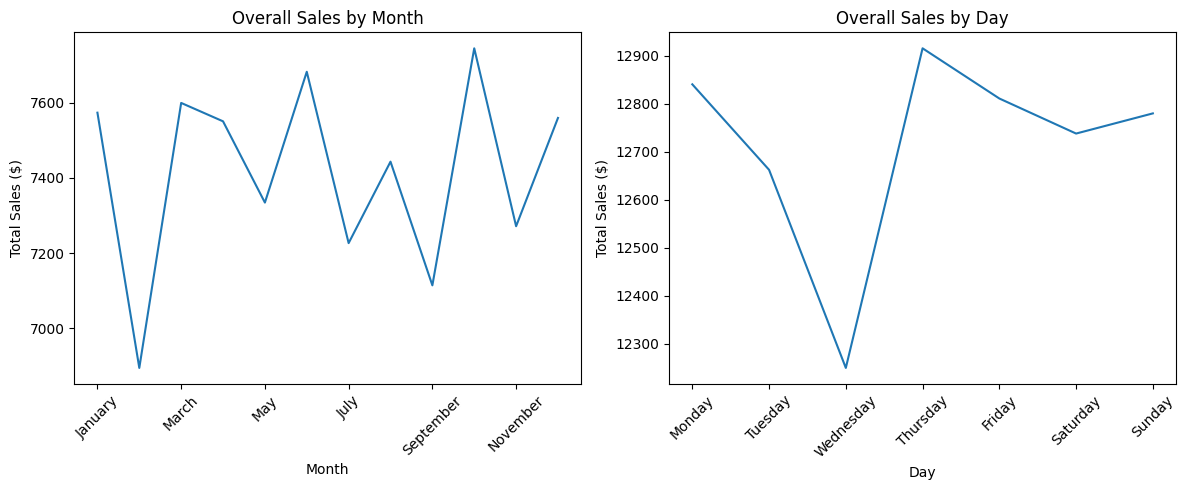

In [166]:
monthly_sales = dirty_cafe.groupby('Transaction Month')['Total Spent'].sum().sort_index()
daily_sales = dirty_cafe.groupby('Transaction Day')['Total Spent'].sum().sort_index()

plt.figure(figsize=(15,4))
plt.subplot(121)
monthly_sales.plot(kind='line', figsize=(12, 5))
plt.xlabel("Month")
plt.ylabel("Total Sales ($)")
plt.title("Overall Sales by Month")
plt.xticks(rotation=45)
plt.subplot(122)
daily_sales.plot(kind='line', figsize=(12, 5))
plt.xlabel("Day")
plt.ylabel("Total Sales ($)")
plt.title("Overall Sales by Day")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\moust\AppData\Local\Temp\ipykernel_15128\2287308284.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  item_monthly_sales = dirty_cafe.groupby(['Transaction Month', 'Item'])['Total Spent'].sum().unstack(fill_value=0)


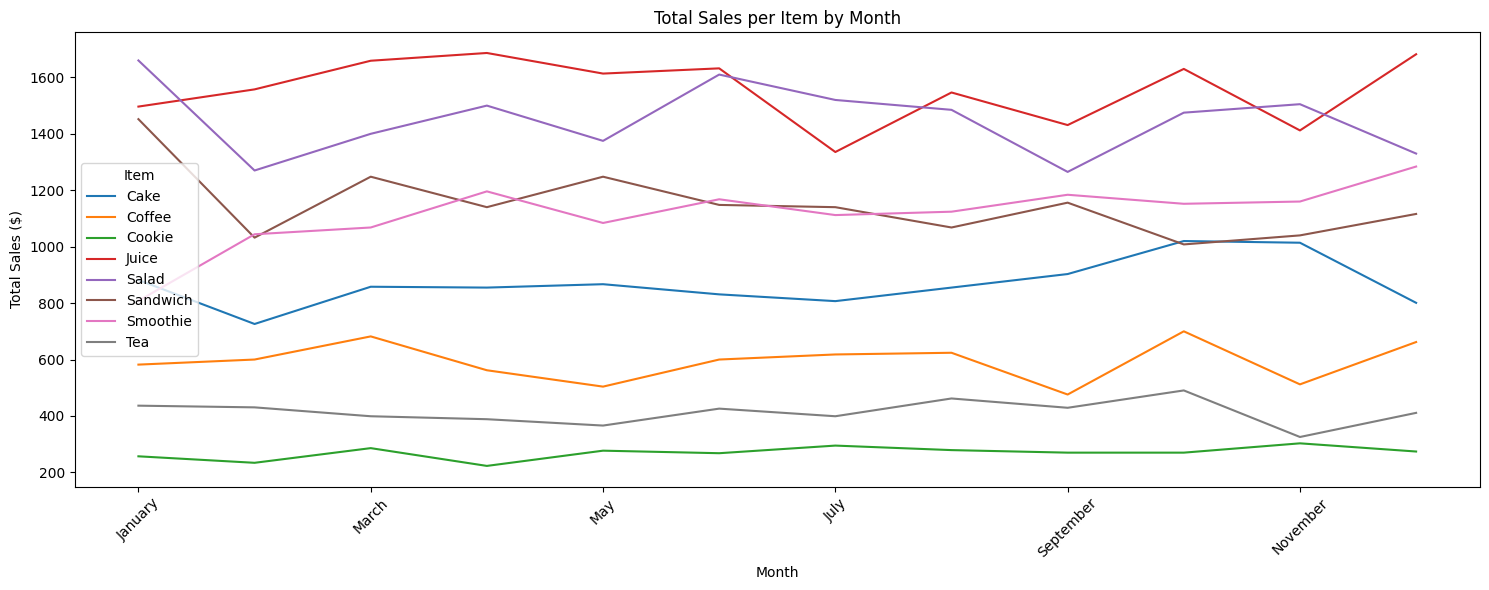

In [167]:
item_monthly_sales = dirty_cafe.groupby(['Transaction Month', 'Item'])['Total Spent'].sum().unstack(fill_value=0)
item_monthly_sales.plot(kind='line', figsize=(15, 6))
plt.xlabel("Month")
plt.ylabel("Total Sales ($)")
plt.title("Total Sales per Item by Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\moust\AppData\Local\Temp\ipykernel_15128\2846898050.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  item_monthly_sales = dirty_cafe.groupby(['Transaction Day', 'Item'])['Total Spent'].sum().unstack(fill_value=0)


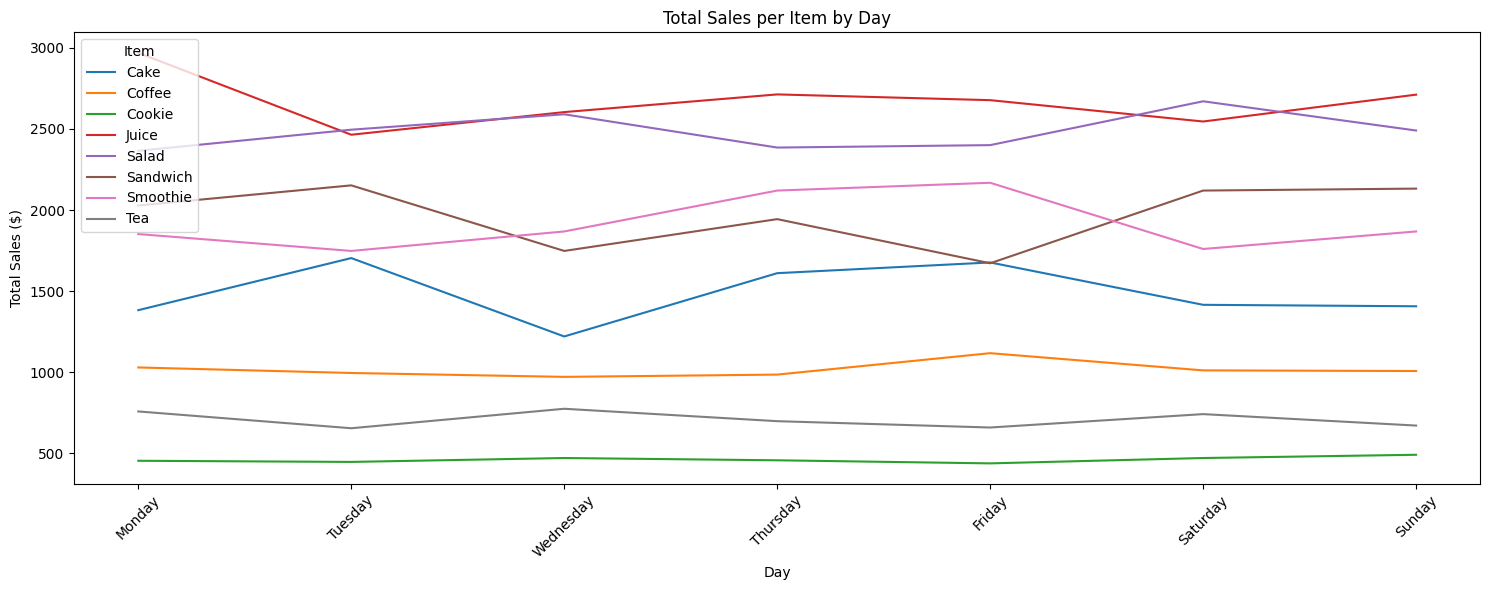

In [168]:
item_monthly_sales = dirty_cafe.groupby(['Transaction Day', 'Item'])['Total Spent'].sum().unstack(fill_value=0)
item_monthly_sales.plot(kind='line', figsize=(15, 6))
plt.xlabel("Day")
plt.ylabel("Total Sales ($)")
plt.title("Total Sales per Item by Day")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**It appers that Our Sales Peaks at October and Thursdays and drops massivly in Febraury and Wednesdays**